In [3]:
import tensorflow as tf
from tensorflow import keras as K

import numpy as np

from tensorflow.keras.layers import Conv2D,Conv2DTranspose,MaxPool2D,Input,concatenate,Lambda,ReLU,Activation
# from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import Sequence
from tensorflow.keras.activations import relu,sigmoid
from tensorflow.keras.losses import Loss
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import Nadam,Adam,RMSprop,SGD
from tensorflow.keras.metrics import BinaryAccuracy
from PIL import Image
import os
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img,img_to_array,load_img
from matplotlib import pyplot as plt
from tqdm import tqdm
from time import time
from tensorflow.keras import backend

In [4]:
PARENT_DIR = os.path.abspath('../DFU Dataset details/DFUC2022_train/DFUC2022_train_release/')
DATA_DIR = os.path.abspath('../DFU Dataset details/DFUC2022_train/DFUC2022_train_release/DFUC2022_train_images')
MASK_DIR = os.path.abspath('../DFU Dataset details/DFUC2022_train/DFUC2022_train_release/DFUC2022_train_masks')
BATCH_SIZE = 32
HEIGHT = 128
WIDTH = 128
CHANNELS = 3 #RGB
INITIAL_FILTER_SIZE = 16

In [5]:
data_filenames = [name for name in os.listdir(DATA_DIR) if name.endswith('.jpg')]
mask_filenames = [name for name in os.listdir(MASK_DIR) if name.endswith('.png')]

#data and mask same names except extensions
file_names = [name[:-4] for name in os.listdir(DATA_DIR) if name.endswith('.jpg')]

In [6]:
file_names.__len__()

2000

In [7]:
class MaskGenerator(Sequence):
    def  __init__(self,file_names,batch_size=64):
        self.file_names = file_names
        self.batch_size = batch_size

    def __len__(self):
        return len(self.file_names)//self.batch_size

    def get_image(self,image_path):

        MASK_PATH = os.path.join(MASK_DIR,(image_path+'.png'))

        #loading mask array from mask path
        mask = img_to_array(load_img(MASK_PATH,target_size=(HEIGHT,WIDTH)))/255.0
        #making mask B&W by rounding off
        # mask = np.around(mask)
        #adding up RGB values([1,1,1]:WHITE,[0,0,0]:BLACK) and rounding off 
        mask = np.around(np.sum(mask,axis=2)/3)
        ##mask = np.sum(mask,axis=2)/3
        #adding a 3rd dimension for 0 or 1 value of pixel
        # mask = mask.reshape(HEIGHT,WIDTH,1)

        # mask = tf.image.resize(tf.io.decode_image(tf.io.read_file(MASK_PATH)),(HEIGHT,WIDTH))

        return mask#.numpy().reshape(HEIGHT,WIDTH,1)
    
    def __getitem__(self,idx):
        batch = self.file_names[idx*self.batch_size:(idx+1)*self.batch_size]
        masks = list()
        for image_path in batch:
            mask = self.get_image(image_path)
            masks.append(mask)
            
        return np.asarray(masks,dtype=np.float32)


In [8]:
datagen = MaskGenerator(file_names,BATCH_SIZE)

In [9]:
acc = tf.keras.metrics.Accuracy()
all_ones = np.ones((HEIGHT,WIDTH,1))
obj_space_per_image = []
for data in tqdm(datagen):
    acc.update_state(data[0],all_ones)
    obj_space_per_image.append(acc.result().numpy())

print('Average % space taken of image')
print('{0:0.2f}%'.format(100*np.mean(obj_space_per_image)))

100%|██████████| 62/62 [00:03<00:00, 18.25it/s]

Average % space taken of image
3.65%


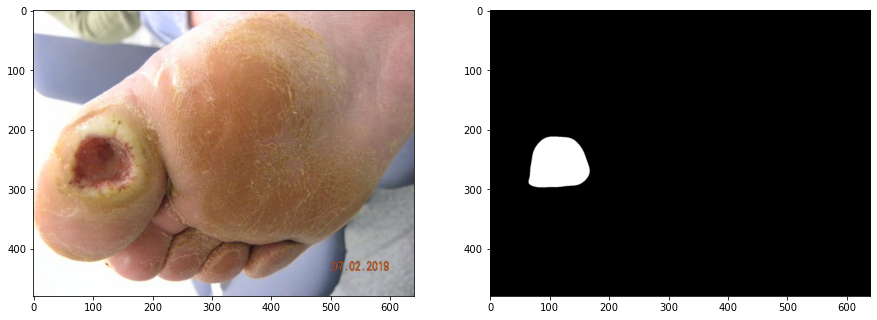

In [10]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(load_img("D:\\Major Project\\DFU Dataset details\\DFUC2022_train\\DFUC2022_train_release\\DFUC2022_train_images\\100002.jpg"))
plt.subplot(1,2,2)
plt.imshow(load_img("D:\\Major Project\\DFU Dataset details\\DFUC2022_train\\DFUC2022_train_release\\DFUC2022_train_masks\\100002.png"))
plt.show()